In [1]:
%load_ext autoreload
%autoreload 2

import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

General settings

In [2]:
ylim = 0.7

# Ablation results

In [3]:
# open store/results.json
with open('store/results.json', 'r') as f:
    cot_results = json.load(f)
nshot_df = pd.DataFrame.from_dict(cot_results, orient='index')
print(len(nshot_df))

56


In [4]:
cols_step_in = { # Select this if we want to leave the step-by-step IN
    0 : {'n_shot' : 0, 'step_by_step' : False, 'no_explanation' : False, 'desc': '0'},
    1 : {'n_shot' : 0, 'step_by_step' : True, 'no_explanation'  : False, 'desc': '0\n"Step-by-step"'},
    2 : {'n_shot' : 1, 'step_by_step' : False, 'no_explanation' : True,  'desc': '1'},
    3 : {'n_shot' : 2, 'step_by_step' : False, 'no_explanation' : True,  'desc': '2'},
    4 : {'n_shot' : 3, 'step_by_step' : False, 'no_explanation' : True,  'desc': '3'},
    5 : {'n_shot' : 4, 'step_by_step' : False, 'no_explanation' : True,  'desc': '4'},
    6 : {'n_shot' : 5, 'step_by_step' : False, 'no_explanation' : True,  'desc': '5'},
}

cols_step_out = { # Select this if we want to leave the step-by-step OUT
    0 : {'n_shot' : 0, 'step_by_step' : False, 'no_explanation' : False, 'desc': '0'},
    1 : {'n_shot' : 1, 'step_by_step' : False, 'no_explanation' : True,  'desc': '1'},
    2 : {'n_shot' : 2, 'step_by_step' : False, 'no_explanation' : True,  'desc': '2'},
    3 : {'n_shot' : 3, 'step_by_step' : False, 'no_explanation' : True,  'desc': '3'},
    4 : {'n_shot' : 4, 'step_by_step' : False, 'no_explanation' : True,  'desc': '4'},
    5 : {'n_shot' : 5, 'step_by_step' : False, 'no_explanation' : True,  'desc': '5'},
}

# cols = cols_step_in
cols = cols_step_out

In [5]:
data = {'arithmetic' : {}, 'presuppositions_as_nli' : {}}
for k, col in cols.items():
    df_mode_acc =  nshot_df[(nshot_df['n_shot'] == col['n_shot']) & (nshot_df['step_by_step'] == col['step_by_step']) & (nshot_df['no_explanation'] == col['no_explanation'])][['model_id',  'accuracy', 'dataset_name']]

    for dataset_name in df_mode_acc['dataset_name'].unique():

        a = df_mode_acc[df_mode_acc['dataset_name'] == dataset_name]

        data[dataset_name][k] = df_mode_acc[df_mode_acc['dataset_name'] == dataset_name].set_index('model_id').to_dict()['accuracy']

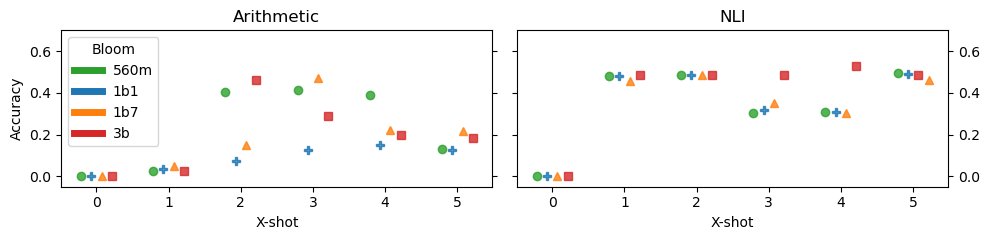

In [6]:
l = 1
l2 = 7

x_ticks = np.arange(len(cols))*l2

colors = {'bigscience/bloom-560m':'tab:green', 'bigscience/bloom-1b1':'tab:blue', 'bigscience/bloom-1b7':'tab:orange', 'bigscience/bloom-3b':'tab:red'}
shapes = {'bigscience/bloom-560m':'o', 'bigscience/bloom-1b1':'P', 'bigscience/bloom-1b7':'^', 'bigscience/bloom-3b':'s'}
shift =  {0 : -1.5*l, 1: -l*0.5, 2: l*0.5, 3: 1.5*l}
tasks = {'arithmetic' : 'Arithmetic', 'presuppositions_as_nli' : 'NLI'}

handles = [
    Line2D([0], [0], color=color, lw=5, label=label.split('-')[-1]) for label, color in colors.items()
]

fig, axs = plt.subplots(1, len(data), figsize=(5*len(data), 2.5), sharey=True, sharex=True, tight_layout=True)

for (task, data_task), ax in zip(data.items(), axs):

    for k, d in data_task.items():
        vals = list(d.values())
        keys = list(d.keys())
        x = [k] * len(vals)

        for i, (val, key) in enumerate(zip(vals, keys)):
            ax.plot(x_ticks[k] + shift[i], [val], marker = shapes[key] , color = colors[key], alpha=0.8)
        # ax.scatter(x, vals, c = [colors[k] for k in keys], alpha=0.5)

    ax.set_xticks(x_ticks)
    ax.set_xticklabels([v['desc'] for v in cols.values()])
    ax.set_xlabel('X-shot')
    ax.set_title(tasks[task])
    ax.set_ylim([-0.05, ylim])

axs[0].set_ylabel('Accuracy')
axs[0].legend(handles = handles, loc = 'upper left', title = 'Bloom')
axs[0].tick_params(right = True)
axs[1].tick_params(labelright = True, right = True)

# fig.suptitle('Performance without CoT or finetuning')
plt.show()


# Few-shot CoT Results

In [7]:
# open store/results.json
with open('store/cot_results.json', 'r') as f:    
    cot_results = json.load(f)

In [8]:
# change the keys eval and train to 0 and 1, they are on the second level
cot_data = {k : {0 : v['eval'], 1 : v['train']} for k, v in cot_results.items()}

In [9]:
cot_cols = {
    0 : {'desc' : 'Direct \nevaluation'},
    1 : {'desc' : 'Finetuning \nwith LoRA'},
}

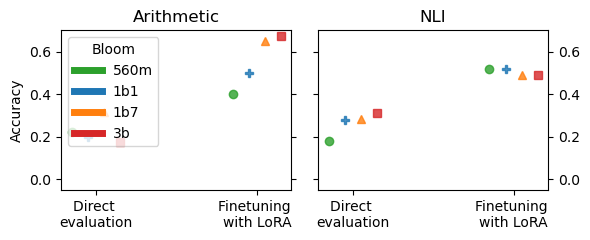

In [10]:
l = 1.
l2 = 7

x_ticks = np.arange(len(cot_cols))*l2

colors = {'bigscience/bloom-560m':'tab:green', 'bigscience/bloom-1b1':'tab:blue', 'bigscience/bloom-1b7':'tab:orange', 'bigscience/bloom-3b':'tab:red'}
shapes = {'bigscience/bloom-560m':'o', 'bigscience/bloom-1b1':'P', 'bigscience/bloom-1b7':'^', 'bigscience/bloom-3b':'s'}
shift =  {0 : -1.5*l, 1: -l*0.5, 2: l*0.5, 3: 1.5*l}
tasks = {'arithmetic' : 'Arithmetic', 'presuppositions_as_nli' : 'NLI'}

handles = [
    Line2D([0], [0], color=color, lw=5, label=label.split('-')[-1]) for label, color in colors.items()
]

fig, axs = plt.subplots(1, len(cot_data), figsize=(3*len(cot_data), 2.5), sharey=True, sharex=True, tight_layout=True)

for (task, data_task), ax in zip(cot_data.items(), axs):

    for k, d in data_task.items():
        vals = list(d.values())
        keys = list(d.keys())
        x = [k] * len(vals)

        for i, (val, key) in enumerate(zip(vals, keys)):
            ax.plot(x_ticks[k] + shift[i], [val], marker = shapes[key] , color = colors[key], alpha=0.8)
        # ax.scatter(x, vals, c = [colors[k] for k in keys], alpha=0.5)

    ax.set_xticks(x_ticks)
    ax.set_xticklabels([v['desc'] for v in cot_cols.values()])
    # ax.set_xlabel('X-shot')
    ax.set_title(tasks[task])
    ax.set_ylim([-0.05, ylim])

axs[0].set_ylabel('Accuracy')
axs[0].legend(handles = handles, loc = 'upper left', title = 'Bloom')
axs[0].tick_params(right = True)
axs[1].tick_params(labelright = True, right = True)

# fig.suptitle('Performance without CoT or finetuning')
plt.show()
